# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация
Дата выдачи: 1.10.2021

Мягкий дедлайн: 17.10.2021 23:59 МСК

Жесткий дедлайн: 24.10.2021 23:59 МСК (1 неделя -- минус балл)

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Загрузите решение в свой репозиторий на github и поделитесь [ссылкой на решение в форме](https://forms.gle/ZzCaqRj6bmfpSpyL7). Не забудьте дать доступ к Вашему репозиторию, что у преподавателей была возмоожность проверить работу.

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [8]:
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(x_train_pics.shape[0], -1)
x_test = x_test_pics.reshape(x_test_pics.shape[0], -1)

__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [139]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
import numpy as np
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.max_sample = 1000000
        
        if self.use_PCA:
            self.PCA = PCA(n_components=self.new_dim)
        
        if self.classifier == 'svm':
            self.classifier_model = SVC(kernel = 'linear', probability=True)
        else:
            self.classifier_model = LogisticRegression(tol = 1e-3, max_iter=10000) 
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        if self.use_PCA:
            X = self.PCA.fit_transform(X)
        
        pairs_num = X.shape[0] ** 2  - X.shape[0]
        if pairs_num > self.max_sample:
            idx = np.random.choice(np.arange(X.shape[0]), size = (self.max_sample, 2))
        else:
            data_idx = np.arange(X.shape[0])
            idx = np.hstack([np.tile(data_idx, X.shape[0]).reshape(-1,1), np.repeat(data_idx,X.shape[0]).reshape(-1,1)])
        idx = idx[idx[:, 0] != idx[:, 1]]
        selected_X = X[idx]
        
        var = np.median(((selected_X[:, 0] - selected_X[:, 1]) ** 2).sum(axis = 1))
        
        self.w = np.random.normal(0, np.sqrt(1/var), size = (self.n_features, X.shape[1]))
        self.b = np.random.uniform(-np.pi, np.pi, size = self.n_features)
        
        X = np.cos((X @ self.w.T) + self.b)
        
        self.classifier_model.fit(X, y)
        
        return self
    
    def transform(self, X):
        if self.use_PCA:
            X = self.PCA.transform(X)
            
        X = np.cos((X @ self.w.T) + self.b)
        return X

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        return self.classifier_model.predict_proba(self.transform(X))
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        return self.classifier_model.predict(self.transform(X))

__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [9]:
# качество классификатора буду считать как макро-усреднение ovr roc-auc - как хорошо классификатор разделяет классы
from sklearn.metrics import roc_auc_score 
from time import time
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

In [10]:
# чтобы у всех были равные условия, все алгоритмы будут обучаься на одной и той же подвыборке данных
subsample_idx = np.random.randint(low = 0, high = x_train.shape[0], size = int(0.2 * x_train.shape[0]))
x_train_subsample, y_train_subsample = x_train[subsample_idx], y_train[subsample_idx]

**RFF**

In [226]:
rff = RFFPipeline(classifier='svm')
start = time()
rff.fit(x_train_subsample, y_train_subsample)
end = time()
rff_train_time = end - start

In [186]:
rff = RFFPipeline(classifier='svm')
start = time()
rff.fit(x_train_subsample, y_train_subsample)
end = time()
rff_train_time = end - start

In [187]:
start = time()
rff_pred = rff.predict_proba(x_test)
end = time()
rff_inference_time = end - start

In [193]:
print(f"SVM with RFF macro ROC-AUC on test sample: {roc_auc_score(y_test, rff_pred, multi_class = 'ovr')}")
print(f'SVM with RFF train time: {np.round(rff_train_time, 2)} seconds')
print(f'SVM with RFF inference time: {np.round(rff_inference_time, 2)} seconds')

SVM with RFF macro ROC-AUC on test sample: 0.9853518666666667
SVM with RFF train time: 77.88 seconds
SVM with RFF inference time: 20.71 seconds


**Linear SVM**

In [157]:
linear_svm = SVC(kernel = 'linear', probability=True)
start = time()
linear_svm.fit(x_train_subsample, y_train_subsample)
end = time()
linear_svm_train_time = end - start

In [158]:
start = time()
linear_svm_pred = linear_svm.predict_proba(x_test)
end = time()
linear_svm_inference_time = end - start

In [179]:
print(f"Linear SVM macro ROC-AUC on test sample: {roc_auc_score(y_test, linear_svm_pred, multi_class = 'ovr')}")
print(f'Linear SVM train time: {np.round(linear_svm_train_time, 2)} seconds')
print(f'Linear SVM inference time: {np.round(linear_svm_inference_time, 2)} seconds')

Linear SVM macro ROC-AUC on test sample: 0.9726525777777777
Linear SVM train time: 142.3 seconds
Linear SVM inference time: 16.42 seconds


**Kernel SVM**

In [160]:
kernel_svm = SVC(probability=True) # по умолчанию rbf-ядро
start = time()
kernel_svm.fit(x_train_subsample, y_train_subsample)
end = time()
kernel_svm_train_time = end - start

In [161]:
start = time()
kernel_svm_pred = kernel_svm.predict_proba(x_test)
end = time()
kernel_svm_inference_time = end - start

In [180]:
print(f"SVM with RBF kernel macro ROC-AUC on test sample: {roc_auc_score(y_test, kernel_svm_pred, multi_class = 'ovr')}")
print(f'SVM with RBF kernel train time: {np.round(kernel_svm_train_time, 2)} seconds')
print(f'SVM with RBF kernel inference time: {np.round(kernel_svm_inference_time, 2)} seconds')

SVM with RBF kernel macro ROC-AUC on test sample: 0.9869283666666666
SVM with RBF kernel train time: 87.29 seconds
SVM with RBF kernel inference time: 37.45 seconds


**PCA + LightGBM**

In [ ]:
lgb_pca = PCA(n_components = 50)
lgb_train = lgb_pca.fit_transform(x_train_subsample)
lgb_test = lgb_pca.transform(x_test)

In [172]:
param_grid = {
    'num_iterations': np.geomspace(10, 1000, 3, dtype = int),
    'learning_rate': np.geomspace(1e-5, 10, 7)
}

In [173]:
lgb_gs = GridSearchCV(LGBMClassifier(), param_grid, scoring = 'roc_auc_ovr', n_jobs = -1, verbose = 5)

In [174]:
lgb_gs.fit(lgb_train, y_train_subsample)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


C:\Users\MAXIM\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


GridSearchCV(estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'learning_rate': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
                         'num_iterations': array([  10,  100, 1000])},
             scoring='roc_auc_ovr', verbose=5)

In [176]:
lgb = LGBMClassifier(**lgb_gs.best_params_, n_jobs = 1) # для чистоты эксперимента пусть считается на одном ядре
start = time()
lgb.fit(lgb_train, y_train_subsample)
end = time()
lgb_train_time = end - start

C:\Users\MAXIM\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [177]:
start = time()
lgb_pred = lgb.predict_proba(lgb_test)
end = time()
lgb_inference_time = end - start

In [181]:
print(f"LightGBM with PCA macro ROC-AUC on test sample: {roc_auc_score(y_test, lgb_pred, multi_class = 'ovr')}")
print(f'LightGBM with PCA train time: {np.round(lgb_train_time, 2)} seconds')
print(f'LightGBM with PCA inference time: {np.round(lgb_inference_time, 2)} seconds')

LightGBM with PCA macro ROC-AUC on test sample: 0.9854452444444444
LightGBM with PCA train time: 39.71 seconds
LightGBM with PCA inference time: 9.8 seconds


**Выводы:** из выводов выше видно, что по ROC-AUC обогнать наш самописный SVM-RFF смог только SVM на RBF-ядре. Ожидаемо, что не у дел остался линейный SVM - всё-таки написанием кода мы хотели аппроксимировать ядро, чтобы получить модель нелинейно зависящую от исходных признаков и надеялись, что с помощью неё поймать нелинейности в функциональной зависимости таргета от данных. Надежды оправдались, RFF выиграл у обычного SVM больше сотой ROC-AUC. Чуть хуже результат показал достаточно глубокий градиентный бустинг - модель сама по себе способная ловить нелинейные зависимости каскадом из решающих деревьев и обладающая низким bias и variance (при грамотном тюнинге гиперпараметров). Тем не менее, она показывает почти такой же результат, как тупая разделяющая поверхность на нелинейных признаках. Ещё один плюс в карму RFF. SVM на RBF ядре выступила чуть лучше. Из лекций мы помним, что RFF аппроксимирует ядра вида $K(x - z)$, RBF-ядро как раз подходит под эту форму, поэтому решено было сравнить с ним. Можно сказать, что мы аппроксимируем какое-то подобное ядро. Ожидаемо, что полноценное ядро смогло обогнать аппроксимацию. Тем не менеее, разница мала, и это можно снова считать плюсом RFF - аппроксимация отрабатывает неплохо.

По скорости обучения SVM-RFF смог обогнать все SVM модели, но не смог обогнать бустинг. Опять же, делая аппроксимацию, мы надеемся, что некоторое ядро у нас получится сымитировать быстрее, чем полноценно его посчитать. Этому требованию аппроксимация удовлетворяет. Интересно, что RBF-ядро посчиталось быстрее, чем линейное. Спишу это на разницу в сходимости и выходки оптимизационной библиотеки, стояещей за классом `sklearn.svm.SVC`. Бустинг обогнать не получилось. Скажу, что это как раз одна из причин, почему бустинг так уважаем, особенно использованный LightGBM, в фокусе которого среди прочего как раз быстродействие. Ну и то, что я говнокодер, тоже определённую роль сыграло)

Бустинг же в разы обогнал всех по скорости инференса. Из моделей SVM обогнать получилось только SVM-RBF, к богатой нелинейности которого мы как раз пытались приблизиться за более краткое время. Линейный SVM предсказал быстрее, так как ему не нужно считать никаие нелинейности, впрочем, разница с SVM-RFF всего четыре секунды - учитывая разницу в качестве, самописный код достойно отработал.

Итого, аппроксимация ядра таким образом, каким мы это проделали здесь, имеет право на жизнь... в мире линейных моделей и sklearn. Соперничать по быстродействию с таким мастодонтами, как LightGBM и другими реализациями бустинга, написанными сообществами крутых программистов, с бэкендом на более низком C++, не вышло. Вынесенный для LightGBM за пределы замеров времени PCA особой роли во временной разнице не играет, так как отрабатывает почти мгновенно. Тем не менее, (1) написанная модель всё ещё проста в реализации, что плюс, (2) она улавливает нелинейный зависимости в данных на уровне 1000-древого LightGBM за какое-то разумное время и (3) бустинг в моей реализации на Python наверняка работал бы дольше), поэтому в принципе подобная парадигма выглядит интересно.

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

In [167]:
from tqdm import tqdm
import matplotlib.pyplot as plt

**Без PCA**

In [183]:
no_pca_rff = RFFPipeline(classifier='svm', use_PCA = False)
start = time()
no_pca_rff.fit(x_train_subsample, y_train_subsample)
end = time()
no_pca_rff_train_time = end - start

In [191]:
start = time()
no_pca_rff_pred = no_pca_rff.predict_proba(x_test)
end = time()
no_pca_rff_inference_time = end - start

In [192]:
no_pca_rff_pred_train = no_pca_rff.predict_proba(x_train_subsample)

In [194]:
print(f"SVM with RFF macro ROC-AUC on train sample: {roc_auc_score(y_train_subsample, no_pca_rff_pred_train, multi_class='ovr')}")
print(f"SVM with RFF macro ROC-AUC on test sample: {roc_auc_score(y_test, no_pca_rff_pred, multi_class = 'ovr')}")
print(f'SVM with RFF train time: {np.round(no_pca_rff_train_time, 2)} seconds')
print(f'SVM with RFF inference time: {np.round(no_pca_rff_inference_time, 2)} seconds')

SVM with RFF macro ROC-AUC on train sample: 0.7825906959324188
SVM with RFF macro ROC-AUC on test sample: 0.503763788888889
SVM with RFF train time: 4190.03 seconds
SVM with RFF inference time: 62.4 seconds


**Выводы:** без PCA получается хуже во всём - из-за больших размерностей считается очень долго и на обучении, и на инференсе, качество по ROC-AUC существенно упало. Специально вывел здесь результаты на тренировочной подвыборке - видно, что модель переобучилась. PCA обладает способностью выделять наиболее полезную информацию из исходных данных. Без неё вместе с полезной информацией мы взяли ещё и вездесущего шума, и в итоге модель на тренировочной подвыборке этот шум выучила, что ударило по её обобщающей способности. Кроме того, даже не тренировочной подвыборке модель работает хуже, чем все ранее рассмотренные нами на тестовой. Вероятно, большая размерность и шумность выборки усложняет поверхность функционала ошибки и сходимость модели.

**Зависимость от n_features**

In [221]:
n_features_range = np.append(np.arange(10, 110, 10), [500, 1000, 5000])
train_times, inference_times, roc_auc_train, roc_auc_test = [], [], [], []

In [222]:
for n_features_value in tqdm(n_features_range):
    model = RFFPipeline(classifier='svm', n_features=n_features_value)
    start = time()
    model.fit(x_train_subsample, y_train_subsample)
    train_times.append(time() - start)
    
    start = time()
    model_pred = model.predict_proba(x_test)
    inference_times.append(time() - start)
    
    model_pred_train = model.predict_proba(x_train_subsample)
    roc_auc_train.append(roc_auc_score(y_train_subsample, model_pred_train, multi_class='ovr'))
    roc_auc_test.append(roc_auc_score(y_test, model_pred, multi_class = 'ovr'))

100%|██████████| 13/13 [16:41<00:00, 77.06s/it] 


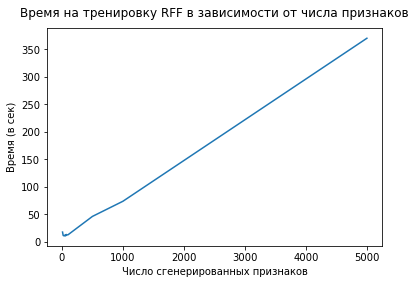

In [251]:
plt.plot(n_features_range, train_times)
plt.title('Время на тренировку RFF в зависимости от числа признаков', y = 1.025)
plt.xlabel('Число сгенерированных признаков')
plt.ylabel('Время (в сек)')
plt.show()

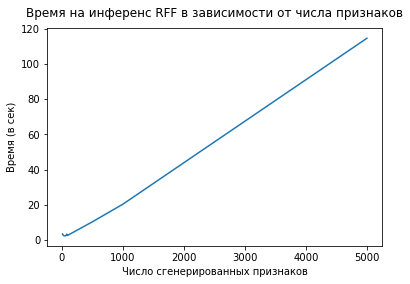

In [250]:
plt.plot(n_features_range, inference_times)
plt.title('Время на инференс RFF в зависимости от числа признаков', y = 1.025)
plt.xlabel('Число сгенерированных признаков')
plt.ylabel('Время (в сек)')
plt.show()

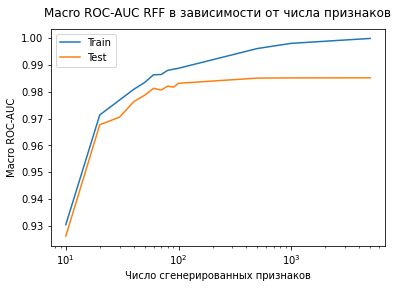

In [252]:
plt.plot(n_features_range, roc_auc_train, label = 'Train')
plt.plot(n_features_range, roc_auc_test, label = 'Test')
plt.xscale('log')
plt.title('Macro ROC-AUC RFF в зависимости от числа признаков', y = 1.025)
plt.xlabel('Число сгенерированных признаков')
plt.ylabel('Macro ROC-AUC')
plt.legend()
plt.show()

**Выводы:** относительно времени тренировки и инференса, даже по тем точкам, что были рассмотрены, видно, что присутствует линейная зависимость от числа сгенерированных признаков. Это ожидаемо - на генерацию каждого нового признаки и учёт каждого отдельного признака в расчётах тратится одинаковое количество времени, поэтому при добавлении ещё одного признака увеличение временных затрат константное. На графике ROC-AUC видно, что где-то после 500 признаков тестовая метрика выходит на плато. Тренировочная, впрочем, продолжает насыщаться с новыми случайными признаками и к 5000 доходит до почти идеального значения метрики. Получается:
- чем больше усилий мы тратим на аппроксимацию ядра, тем больше модель подгоняется под тренировочные данные
- существует некий порог аппроксимации, после которого предсказательная сила модели на неизвестных данных не растёт, то есть модель уже нашла адекватную форму скрытой функциональной зависимости

Это имеет смысл для рассматриваемой задачи, но возможно подобный паттерн будет присутствовать и на других данных.

**Логрег и SVM**

Для чистоты эксперимента в классе `RFFPipeline` выше я выставил для `LogisticRegression` параметр `tol` равный 1e-3, как и у используемого класса метода опорных векторов `SVC`, и поднял `max_iter`, чтобы дать регрессии возможность сойтись (у `SVC` число итераций не ограничено).

In [180]:
logreg_rff = RFFPipeline(classifier='logreg', n_features = 1000)
start = time()
logreg_rff.fit(x_train_subsample, y_train_subsample)
end = time()
logreg_rff_train_time = end - start

In [181]:
start = time()
logreg_rff_pred = logreg_rff.predict_proba(x_test)
end = time()
logreg_rff_inference_time = end - start

In [182]:
svm_rff = RFFPipeline(classifier='svm', n_features = 1000)
start = time()
svm_rff.fit(x_train_subsample, y_train_subsample)
end = time()
svm_rff_train_time = end - start

In [183]:
start = time()
svm_rff_pred = svm_rff.predict_proba(x_test)
end = time()
svm_rff_inference_time = end - start

In [184]:
print(f"SVM with RFF macro ROC-AUC on test sample: {roc_auc_score(y_test, svm_rff_pred, multi_class = 'ovr')}")
print(f"Logreg with RFF macro ROC-AUC on test sample: {roc_auc_score(y_test, logreg_rff_pred, multi_class = 'ovr')}\n")

print(f'SVM with RFF train time: {np.round(svm_rff_train_time, 2)} seconds')
print(f'Logreg with RFF train time: {np.round(logreg_rff_train_time, 2)} seconds\n')

print(f'SVM with RFF inference time: {np.round(svm_rff_inference_time, 2)} seconds')
print(f'Logreg with RFF inference time: {np.round(logreg_rff_inference_time, 2)} seconds')

SVM with RFF macro ROC-AUC on test sample: 0.9860217666666667
Logreg with RFF macro ROC-AUC on test sample: 0.9859112444444446

SVM with RFF train time: 73.35 seconds
Logreg with RFF train time: 165.47 seconds

SVM with RFF inference time: 19.1 seconds
Logreg with RFF inference time: 0.36 seconds


**Выводы:** логистческая регрессия обучается дольше SVM и других алгоритмов, рассмотренных выше, но предсказывает в разы быстрее. Стоит заметить, что под капотом этих классов применяются различные оптимизационные библиотеки - это может влиять на разницу в скорости. Качество моделей сравнимое - разница в десятитысячной доле в пользу SVM. По результатам сложно отдать предпочтение какому-либо из алгоритмов. Если модель на практике дополняется данными для обучения не часто, то лучше, чтобы предсказание было быстрым - тогда ваш выбор за логрегом. Если модель чаще доообучается - то рациональным выбором будет SVM.

### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

In [ ]:
from scipy.stats import chi

In [159]:
class ORFPipeline(RFFPipeline):     
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, ORF, Classification) to training set.
        """
        if self.use_PCA:
            X = self.PCA.fit_transform(X)
        
        pairs_num = X.shape[0] ** 2  - X.shape[0]
        if pairs_num > self.max_sample:
            idx = np.random.choice(np.arange(X.shape[0]), size = (self.max_sample, 2))
        else:
            data_idx = np.arange(X.shape[0])
            idx = np.hstack([np.tile(data_idx, X.shape[0]).reshape(-1,1), np.repeat(data_idx,X.shape[0]).reshape(-1,1)])
        idx = idx[idx[:, 0] != idx[:, 1]]
        selected_X = X[idx]
        
        var = np.median(((selected_X[:, 0] - selected_X[:, 1]) ** 2).sum(axis = 1))
        
        n_generations = int(np.ceil(self.n_features / X.shape[1]))
        generated_matrices = []
        for _ in range(n_generations):
            w_rff = np.random.normal(0, 1, size = (X.shape[1], X.shape[1]))
            q, _ = np.linalg.qr(w_rff, mode='complete')
            s = np.eye(q.shape[0])
            s[np.diag_indices_from(s)] = chi.rvs(w_rff.shape[1], size=s.shape[0])
            w_orf = s @ q
            generated_matrices.append(w_orf)
        self.w = np.vstack(generated_matrices)
        if self.w.shape[0] > self.n_features:
            self.w = self.w[:self.n_features]
            
        self.w /= np.sqrt(var)
        
        self.b = np.random.uniform(-np.pi, np.pi, size = self.n_features)
        
        X = np.cos((X @ self.w.T) + self.b) 
        
        self.classifier_model.fit(X, y)
        
        return self

Повторю некоторые эксперименты из предыдущего пункта.

**Зависимость от n_features**

In [165]:
n_features_range = np.append(np.arange(10, 110, 10), [500, 1000, 5000])
train_times, inference_times, roc_auc_train, roc_auc_test = [], [], [], []

In [168]:
for n_features_value in tqdm(n_features_range):
    model = ORFPipeline(classifier='svm', n_features=n_features_value)
    start = time()
    model.fit(x_train_subsample, y_train_subsample)
    train_times.append(time() - start)
    
    start = time()
    model_pred = model.predict_proba(x_test)
    inference_times.append(time() - start)
    
    model_pred_train = model.predict_proba(x_train_subsample)
    roc_auc_train.append(roc_auc_score(y_train_subsample, model_pred_train, multi_class='ovr'))
    roc_auc_test.append(roc_auc_score(y_test, model_pred, multi_class = 'ovr'))

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [15:07<00:00, 69.82s/it]


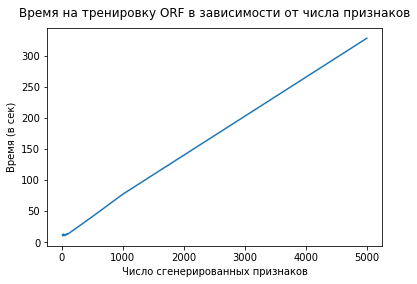

In [169]:
plt.plot(n_features_range, train_times)
plt.title('Время на тренировку ORF в зависимости от числа признаков', y = 1.025)
plt.xlabel('Число сгенерированных признаков')
plt.ylabel('Время (в сек)')
plt.show()

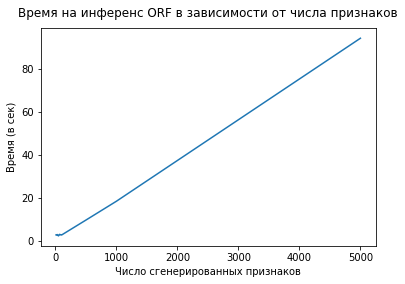

In [170]:
plt.plot(n_features_range, inference_times)
plt.title('Время на инференс ORF в зависимости от числа признаков', y = 1.025)
plt.xlabel('Число сгенерированных признаков')
plt.ylabel('Время (в сек)')
plt.show()

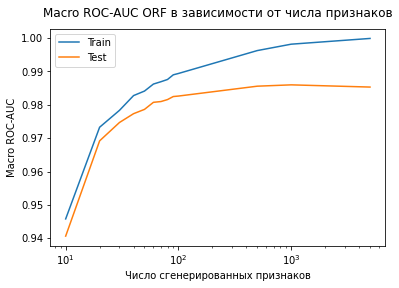

In [171]:
plt.plot(n_features_range, roc_auc_train, label = 'Train')
plt.plot(n_features_range, roc_auc_test, label = 'Test')
plt.xscale('log')
plt.title('Macro ROC-AUC ORF в зависимости от числа признаков', y = 1.025)
plt.xlabel('Число сгенерированных признаков')
plt.ylabel('Macro ROC-AUC')
plt.legend()
plt.show()

**Выводы:** графики изменились не сильно. Из отличий можно выделить следующее:
- значения ROC-AUC для минимального числа сгенерированных признаков выше - порядка 0.945 для трейна и 0.94 для теста против 0.93 и 0.925 у RFF аппорксимации. Выходит, для таких значений параметра ORF аппроксимация работает существенно лучше
- разница между результатами на тренировочной и тестовой выборках для ORF больше
- наблюдается некоторое снижение тестовой метрики при переходе от 1000 к 5000 сгенерированных признаков

Изначальная идея ORF - предоставить алгоритму некореллированные признаки. В парадигме аппроксимации ядер этого добиваются путём QR-разложения случайно сгенерированной матрицы, чтобы получить ортогональные векторы весов. Есть подозрение, что эта "случайная ортогональность" в модели может насытиться разными подобными векторами: при большом числе уже сгенерированных признаков сгенерировать ещё некореллированных признаков становится сложно. Новые признаки будут уже не такими крутыми и подпорят результат. А каким образом подпортят? Из МО-1 помним, что скоррелированные признаки сопряжен с понятием переобучения, когда модель подгоняется под тренировочную выборку так сильно, что начинает терять в обобщающей способности и показывать субоптимальный результат на неизвестных данных. По моему предположению, здесь после 1000 признаков происходит как раз это. При это метрика вряд ли опустится ниже, чем у RFF аппроксимации, которая обучалась вообще на любых признаках и не парилась по поводу из скоррелированности.

**Логрег и SVM**

In [185]:
logreg_orf = ORFPipeline(classifier='logreg', n_features = 1000)
start = time()
logreg_orf.fit(x_train_subsample, y_train_subsample)
end = time()
logreg_orf_train_time = end - start

In [186]:
start = time()
logreg_orf_pred = logreg_orf.predict_proba(x_test)
end = time()
logreg_orf_inference_time = end - start

In [187]:
svm_orf = ORFPipeline(classifier='svm', n_features = 1000)
start = time()
svm_orf.fit(x_train_subsample, y_train_subsample)
end = time()
svm_orf_train_time = end - start

In [188]:
start = time()
svm_orf_pred = svm_orf.predict_proba(x_test)
end = time()
svm_orf_inference_time = end - start

In [189]:
print(f"SVM with ORF macro ROC-AUC on test sample: {roc_auc_score(y_test, svm_orf_pred, multi_class = 'ovr')}")
print(f"Logreg with ORF macro ROC-AUC on test sample: {roc_auc_score(y_test, logreg_orf_pred, multi_class = 'ovr')}\n")

print(f'SVM with ORF train time: {np.round(svm_orf_train_time, 2)} seconds')
print(f'Logreg with ORF train time: {np.round(logreg_orf_train_time, 2)} seconds\n')

print(f'SVM with ORF inference time: {np.round(svm_orf_inference_time, 2)} seconds')
print(f'Logreg with ORF inference time: {np.round(logreg_orf_inference_time, 2)} seconds')

SVM with RFF macro ROC-AUC on test sample: 0.9862111
Logreg with RFF macro ROC-AUC on test sample: 0.9860905777777779

SVM with RFF train time: 71.53 seconds
Logreg with RFF train time: 177.22 seconds

SVM with RFF inference time: 18.85 seconds
Logreg with RFF inference time: 0.37 seconds


**Выводы:** по скорости работы получается почти то же, что и у RFF. В принципе, ожидаемо ведь алгоритмы отличаются только наличием в ORF только циклом генерации случайных матриц. Он как раз и может быть ответственнен за увеличение времени работы. Результаты тоже стали получше - оба классификатора отыграли десятитысячные доли. Отдать предпочтение чему-то опять же сложно. Всё зависит от того, что конкретный специалист будет ставить во главу угла в определённой ситуации - время работы или наилучший возможный результат.

__Задание 5. (Максимум 2 балла)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

In [219]:
# класс для подстановки генерационных функций
class FlexibleRFFPipeline(RFFPipeline):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg', gen_func = np.cos):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Orthogonal Random Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.max_sample = 1000000
        self.gen_func = gen_func
        
        if self.use_PCA:
            self.PCA = PCA(n_components=self.new_dim)
        
        if self.classifier == 'svm':
            self.classifier_model = SVC(kernel = 'linear', probability=True)
        else:
            self.classifier_model = LogisticRegression(tol = 1e-3, max_iter=10000)
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, ORF, Classification) to training set.
        """
        if self.use_PCA:
            X = self.PCA.fit_transform(X)
        
        pairs_num = X.shape[0] ** 2  - X.shape[0]
        if pairs_num > self.max_sample:
            idx = np.random.choice(np.arange(X.shape[0]), size = (self.max_sample, 2))
        else:
            data_idx = np.arange(X.shape[0])
            idx = np.hstack([np.tile(data_idx, X.shape[0]).reshape(-1,1), np.repeat(data_idx,X.shape[0]).reshape(-1,1)])
        idx = idx[idx[:, 0] != idx[:, 1]]
        selected_X = X[idx]
        
        var = np.median(((selected_X[:, 0] - selected_X[:, 1]) ** 2).sum(axis = 1))
        
        n_generations = int(np.ceil(self.n_features / X.shape[1]))
        generated_matrices = []
        for _ in range(n_generations):
            w_rff = np.random.normal(0, 1, size = (X.shape[1], X.shape[1]))
            q, _ = np.linalg.qr(w_rff, mode='complete')
            s = np.eye(q.shape[0])
            s[np.diag_indices_from(s)] = chi.rvs(w_rff.shape[1], size=s.shape[0])
            w_orf = s @ q
            generated_matrices.append(w_orf)
        self.w = np.vstack(generated_matrices)
        if self.w.shape[0] > self.n_features:
            self.w = self.w[:self.n_features]
            
        self.w /= np.sqrt(var)
        
        self.b = np.random.uniform(-np.pi, np.pi, size = self.n_features)
        
        X = self.gen_func((X @ self.w.T) + self.b) 
        
        self.classifier_model.fit(X, y)
        
        return self
    
    def transform(self, X):
        if self.use_PCA:
            X = self.PCA.transform(X)
            
        X = self.gen_func((X @ self.w.T) + self.b)
        return X

**Знак**

In [193]:
logreg_sign = FlexibleRFFPipeline(classifier='logreg', n_features = 1000, gen_func=np.sign)
logreg_sign.fit(x_train_subsample, y_train_subsample)

FlexibleRFFPipeline(gen_func=<ufunc 'sign'>)

In [194]:
logreg_sign_pred = logreg_sign.predict_proba(x_test)

In [195]:
svm_sign = FlexibleRFFPipeline(classifier='svm', n_features = 1000, gen_func=np.sign)
svm_sign.fit(x_train_subsample, y_train_subsample)

FlexibleRFFPipeline(classifier='svm', gen_func=<ufunc 'sign'>)

In [196]:
svm_sign_pred = svm_sign.predict_proba(x_test)

In [197]:
print(f"SVM with RFF macro ROC-AUC on test sample: {roc_auc_score(y_test, svm_sign_pred, multi_class = 'ovr')}")
print(f"Logreg with RFF macro ROC-AUC on test sample: {roc_auc_score(y_test, logreg_sign_pred, multi_class = 'ovr')}")

SVM with RFF macro ROC-AUC on test sample: 0.9756876555555556
Logreg with RFF macro ROC-AUC on test sample: 0.9751454555555557



**Вывод по знаку:** стало хуже, не прямо ужасно, но потеряна сота доля. Знак даёт меньше информации, чем косинус - теряется амплитуда значений. Это и могло стать причиной падаения метрики.